# NYC Taxi Pickups Analysis


In [ ]:
# Software to download files
!pip install gdown

In [ ]:
# Install Spark
!apt-get install openjdk-17-jdk-headless
!pip install pyspark==4.0.0.dev2
!mkdir checkpoint


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk-headless is already the newest version (17.0.14+7-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
mkdir: cannot create directory ‘checkpoint’: File exists


In [ ]:
# Install RAPIDS - for using cuDF, cuML
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 8.85 MiB/s, done.
Resolving deltas: 100% (299/299), done.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pynvml.py", line 2415, in _LoadNvmlLibrary
    nvmlLib = CDLL("libnvidia-ml.so.1")
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: libnvidia-ml.so.1: cannot open shared object file: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 18, in <module>
    

# Setup

The data sets are available in the following link: https://drive.google.com/drive/folders/1WMwLUj0t4Q0GSll96lbF2bDjaPVh1w8z?usp=sharing. For running in Google Colab, you should access the link and Add Shortcut to your Drive.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/assignment1

Mounted at /content/drive
sample.csv.gz  sorted_data.csv.gz  tiny.csv.gz


Next cells setup: Pandas, Spark and cuDF/cuML.

In [ ]:
# General imports
import timeit

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster


In [ ]:
# Imports for Spark

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# imports Spark SQL and Pandas API
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
import pyspark.pandas as ps

# this sets the maximum number of rows to show when printing pandas Dataframes
ps.set_option('display.max_rows', 10)



AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

In [ ]:
# Imports for cuDF / cuML

import cudf
import cupy as cp
from cuml import cluster

In [ ]:
# Setup the dataset being used

# Large dataset - 12.3 GB compressed
FILENAME_large = "/content/drive/MyDrive/assignment1/sorted_data.csv.gz"

# Small dataset - 135 MB compressed
FILENAME_small = "/content/drive/MyDrive/assignment1/sample.csv.gz"

# Tiny dataset - 6.8 MB compressed (you can use this one for speeding up development only)
#FILENAME = "/content/drive/MyDrive/assignment1/tiny.csv.gz"


## Simple statistics

We will print some simple statistics.

In [ ]:
import matplotlib.pyplot as plt
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

start_time = time.time()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME_small, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

statistics = spark.sql( """SELECT COUNT( DISTINCT medallion) AS num_medallion,
                                  COUNT( DISTINCT hack_license) AS num_license,
                                  MIN( pickup_datetime) AS min_pickup,
                                  MAX( dropoff_datetime) AS max_dropoff,
                                  MAX( trip_time_in_secs) AS max_trip_time,
                                  MAX( trip_distance) AS max_trip_distance,
                                  MAX( total_amount) AS max_total_amount
                                  FROM data""")
statistics.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|num_medallion|num_license|         min_pickup|        max_dropoff|max_trip_time|max_trip_distance|max_total_amount|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|        10867|      20354|2013-01-01 00:00:00|2013-01-21 00:11:45|        10800|            95.85|           465.0|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+

Runtime = 26.61409568786621


## Ploting information


### First plot

This first plot helps showing that data has several invalid values.

Let's plot the pickups.

Plotting pickups


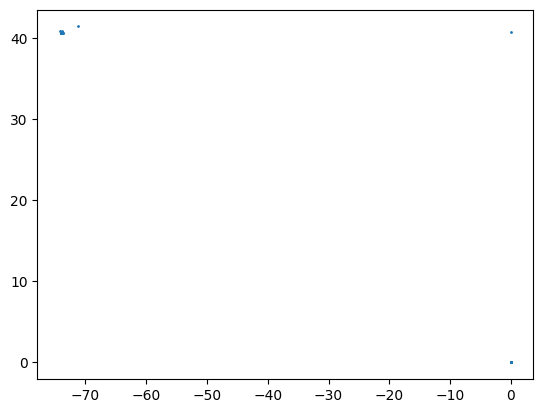

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME_small, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# Plotting all points is probably too much in many computers, so lets plot only a few 1000's
data = spark.sql( "SELECT * FROM data LIMIT 1000")
pickups = data.collect()

print('Plotting pickups')
plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            s=1)
plt.show()


### Plotting heatamps

Plotting pickups


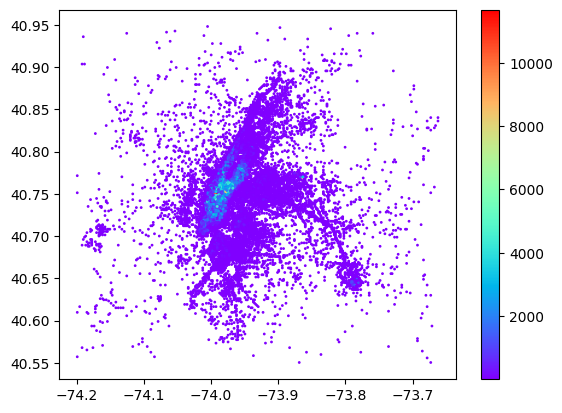

Plotting pickups


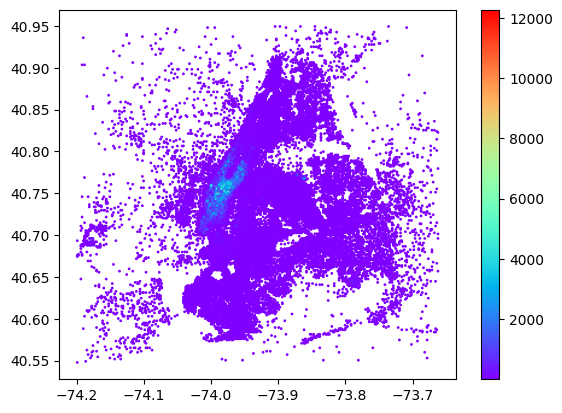

In [ ]:
# Squares of 500 meters
#latitudeStep = 0.004491556
#longitudeStep = 0.005986
#northLatitude = 41.474937 - 0.5 * latitudeStep
#southLatitude = northLatitude - 300 * latitudeStep
#eastLongitude = -74.913585 - 0.5 * longitudeStep
#westLongitude = eastLongitude + 300 * longitudeStep

# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.2
westLongitude = eastLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME_small, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            c=[row.cnt for row in pickups],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()

# Statistics for pickups
dropoffsDF = spark.sql( """SELECT dropoff_longitude, dropoff_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY dropoff_longitude, dropoff_latitude""")
dropoffs = dropoffsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.dropoff_longitude for row in dropoffs],
            [row.dropoff_latitude for row in dropoffs],
            c=[row.cnt for row in dropoffs],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()



## Most frequent routes

20 most frequent routes whose distance is above a given treshold.

# Spark SQL

In [ ]:
# COMPLETE with Spark SQL code

start_time = time.time()

# Define the threshold distance
distance_threshold = 2.0

# Squares of 500 meters
latitudeStep = 0.004491556
longitudeStep = 0.005986
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.2
westLongitude = eastLongitude + 300 * longitudeStep

dataset = spark.read.load(FILENAME_small, format="csv", sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# Filter and group data to find the most frequent routes above the distance threshold
routesDF = spark.sql(f"""SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, COUNT(*) AS frequency
                         FROM (
                          SELECT
                            FLOOR((pickup_longitude - {eastLongitude}) / {longitudeStep}) * {longitudeStep} + {eastLongitude} + {longitudeStep} / 2 AS pickup_longitude,
                            {northLatitude} - FLOOR(({northLatitude} - pickup_latitude) / {latitudeStep}) * {latitudeStep} - {latitudeStep} / 2 AS pickup_latitude,
                            FLOOR((dropoff_longitude - {eastLongitude}) / {longitudeStep}) * {longitudeStep} + {eastLongitude} + {longitudeStep} / 2 AS dropoff_longitude,
                            {northLatitude} - FLOOR(({northLatitude} - dropoff_latitude) / {latitudeStep}) * {latitudeStep} - {latitudeStep} / 2 AS dropoff_latitude,
                            trip_distance
                          FROM data
                          WHERE trip_distance > {distance_threshold}
                         )
                         GROUP BY pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
                         ORDER BY frequency DESC
                         LIMIT 20""")

routes = routesDF.collect()

end_time = time.time()

# Display the results
for route in routes:
  print(route)

print("Run time = " + str(end_time-start_time))

Row(pickup_longitude=Decimal('-0.00053700'), pickup_latitude=Decimal('-0.00176183000'), dropoff_longitude=Decimal('-0.00053700'), dropoff_latitude=Decimal('-0.00176183000'), frequency=11183)
Row(pickup_longitude=Decimal('-73.87376300'), pickup_latitude=Decimal('40.77258353800'), dropoff_longitude=Decimal('-73.98151100'), dropoff_latitude=Decimal('40.76360042600'), frequency=591)
Row(pickup_longitude=Decimal('-73.87376300'), pickup_latitude=Decimal('40.77258353800'), dropoff_longitude=Decimal('-73.98749700'), dropoff_latitude=Decimal('40.75910887000'), frequency=537)
Row(pickup_longitude=Decimal('-73.87376300'), pickup_latitude=Decimal('40.77258353800'), dropoff_longitude=Decimal('-73.97552500'), dropoff_latitude=Decimal('40.75012575800'), frequency=488)
Row(pickup_longitude=Decimal('-73.98151100'), pickup_latitude=Decimal('40.76360042600'), dropoff_longitude=Decimal('-73.87376300'), dropoff_latitude=Decimal('40.77258353800'), frequency=453)
Row(pickup_longitude=Decimal('-73.98749700'),

# Spark Pandas API

In [ ]:
# COMPLETE with Spark Pandas API code
import pyspark.pandas as ps

start_time = time.time()

# We will use the same distance threshold and variables defined on the previous code

# Load the dataset using Spark Pandas API
mySchemaPandas = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"]

dataset = ps.read_csv(FILENAME_small, names=mySchemaPandas)

# Filter and group data to find the most frequent routes
dataset = dataset[(dataset["pickup_longitude"] >= eastLongitude) &
                  (dataset["pickup_longitude"] <= westLongitude) &
                  (dataset["dropoff_longitude"] >= eastLongitude) &
                  (dataset["dropoff_longitude"] <= westLongitude) &
                  (dataset["pickup_latitude"] <= northLatitude) &
                  (dataset["pickup_latitude"] >= southLatitude) &
                  (dataset["dropoff_latitude"] <= northLatitude) &
                  (dataset["dropoff_latitude"] >= southLatitude) &
                  (dataset["trip_distance"] > distance_threshold)]

dataset["pickup_longitude"]=((dataset["pickup_longitude"] - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
dataset["pickup_latitude"]= northLatitude - ((northLatitude - dataset["pickup_latitude"]) // latitudeStep) * latitudeStep - latitudeStep / 2
dataset["dropoff_longitude"]=((dataset["dropoff_longitude"] - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
dataset["dropoff_latitude"]=northLatitude - ((northLatitude - dataset["dropoff_latitude"]) // latitudeStep) * latitudeStep - latitudeStep / 2

result = dataset.groupby(["pickup_longitude", "pickup_latitude", "dropoff_latitude", "dropoff_longitude"]).size().reset_index(name="frequency")
result = result.sort_values(by="frequency", ascending=False).head(20)

end_time = time.time()

print(result)

print("Run time = " + str(end_time-start_time))

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


        pickup_longitude  pickup_latitude  dropoff_latitude  dropoff_longitude  frequency
73229         -73.873763        40.772584         40.763600         -73.981511        591
63941         -73.873763        40.772584         40.759109         -73.987497        537
2509          -73.873763        40.772584         40.750126         -73.975525        488
108013        -73.981511        40.763600         40.772584         -73.873763        453
59295         -73.987497        40.759109         40.772584         -73.873763        452
2493          -73.987497        40.759109         40.768092         -73.861791        451
42076         -73.981511        40.763600         40.741143         -74.005455        418
99739         -74.005455        40.741143         40.763600         -73.981511        416
46231         -73.873763        40.772584         40.754617         -73.975525        413
102759        -73.981511        40.763600         40.768092         -73.861791        411

[Showing 

#### Discussion

**Spark SQL solution:**
- Data preparation: The first part of the code defines the grid with a step size of 500 meters, diving the city into latitude and longitude cells.
- SQL Query: The spark.sql() function filters the data to include only trips whose distance exceeds the threshold (defined as 2.0 in our example). It groups the data by pickup and dropoff coordinates and calculates the frequency of these routes.
- Grouping and filtering: After filtering, it orders the results by frequency in descending order and limits the output to the top 20 frequent routes.
- Distance calculation: The computation of the distance between the pickup and dropoff locations using the floor() function to round down the latitude and longitude values into the predefined grid cells.

**Spark Pandas API solution:**
- Data loading: the dataset is loaded into a Pandas on Spark framework using ps.read_csv().
- Data filtering: Similar to the SQL approach, it filters the data based on the pickup and dropoff coordinaties falling within the grid an with trip distances greater than the threshold.
- Grouping and aggregation: The data is then grouped by the relevant gropraphical coordinates and counted for frquency. The results are sorted by frequency in descending order and limited to the top 20.
- Sorting: The final result is obtained by grouping the data and sorting it by frequency.

**Discussion:**
Spark SQL approach appears to be more suitable as it leverages the Spark's distributed computation. It works well for structured queries and scales efficiently with large amounts of data. The Spark Pandas API provides a more intuitive and familiar interface for users of the Pandas library, however it performed a bit slower than the SQL code (with 26s vs 14s) as it relies on Python objects and in-memory processing.

## Location of taxi ranks to minimize distances

Location of taxi ranks / taxi stand (the places where taxis stop waiting for collecting clients) in a way that tries to minimize the distance a client needs to walk to reach a taxi rank.

**Note:** This dataset is for NYC taxis. So, pickups outside of the city are infrequent and not representative of the demand in such areas. As such, we focus on pickups in a square that includes NYC (it is ok if the square includes parts outside of the city).

Execution time: 4.698190450668335


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


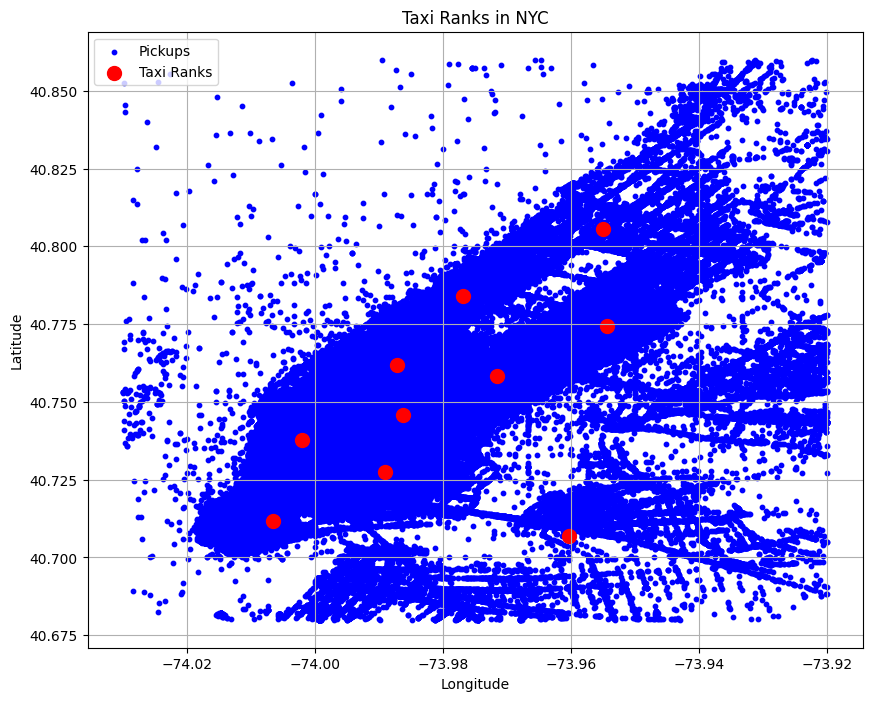

In [ ]:
# COMPLETE with code using scikit-learn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import time

# Define the square for NYC
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92

# Read file
dataset = spark.read.load(FILENAME_small, format='csv', sep=',', schema=mySchema, header='false')
dataset.createOrReplaceTempView("data")

# Define the square for NYC
pickups = [(row.pickup_longitude, row.pickup_latitude) for row in spark.sql("SELECT pickup_longitude, pickup_latitude FROM data").collect()]
nyc_pickups = [(row[0], row[1]) for row in pickups if
               southLatitude <= row[1] <= northLatitude and
               eastLongitude <= row[0] <= westLongitude]

# Convert to numpy array
pickup_coords = np.array(nyc_pickups)

# Start timing
start_time = time.time()

# Apply Kmeans clustering to find the taxi ranks
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(pickup_coords)

# End timing
end_time = time.time()

# Print execution time
print("Execution time:", end_time - start_time)

#Plot the results as a heatmap
plt.figure(figsize=(10,8))
plt.scatter(pickup_coords[:, 0], pickup_coords[:, 1], c='blue', s=10, label='Pickups')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], c='red', s=100, label='Taxi Ranks')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Taxi Ranks in NYC')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


Execution time (cuML): 1.8736121654510498


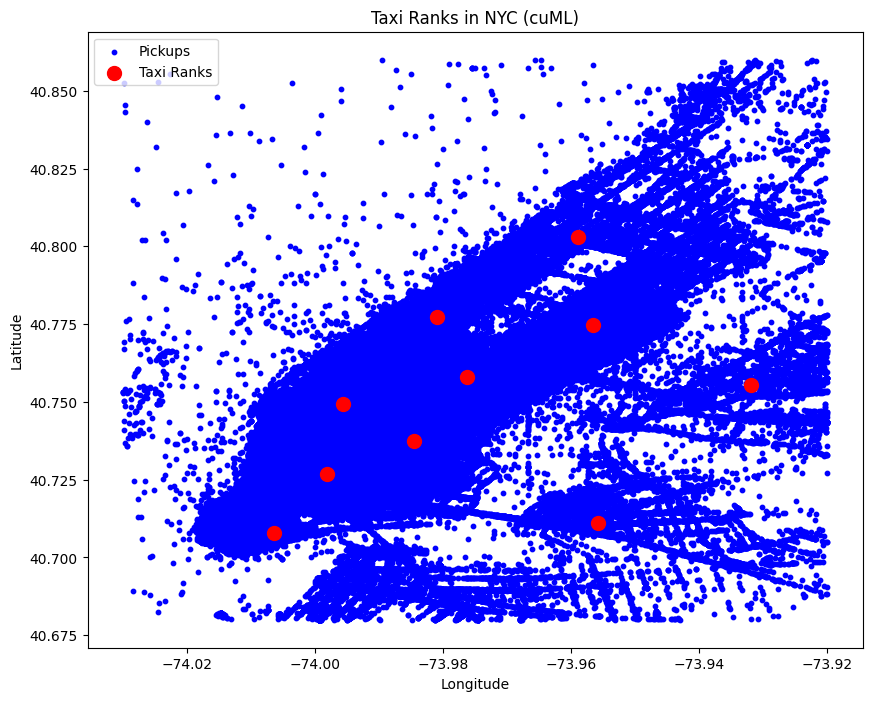

In [ ]:
# COMPLETE with code using cuML

from cuml.cluster import KMeans as cuKMeans

# Start timing
start_time = time.time()

# Apply cuML KMeans clustering to find taxi ranks
kmeans_cuml = cuKMeans(n_clusters=num_clusters, random_state=42)
kmeans_cuml.fit(pickup_coords)

# End timing
end_time = time.time()

# Print execution time
print("Execution time (cuML):", end_time - start_time)

# Plot the results as a heatmap
plt.figure(figsize=(10,8))
plt.scatter(pickup_coords[:,0], pickup_coords[:,1], c='blue', s=10, label='Pickups')
plt.scatter(kmeans_cuml.cluster_centers_[:,0], kmeans_cuml.cluster_centers_[:,1], c='red', s=100, label='Taxi Ranks')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Taxi Ranks in NYC (cuML)')
plt.legend()
plt.show()

Execution time (Spark MLib): 102.27312135696411


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


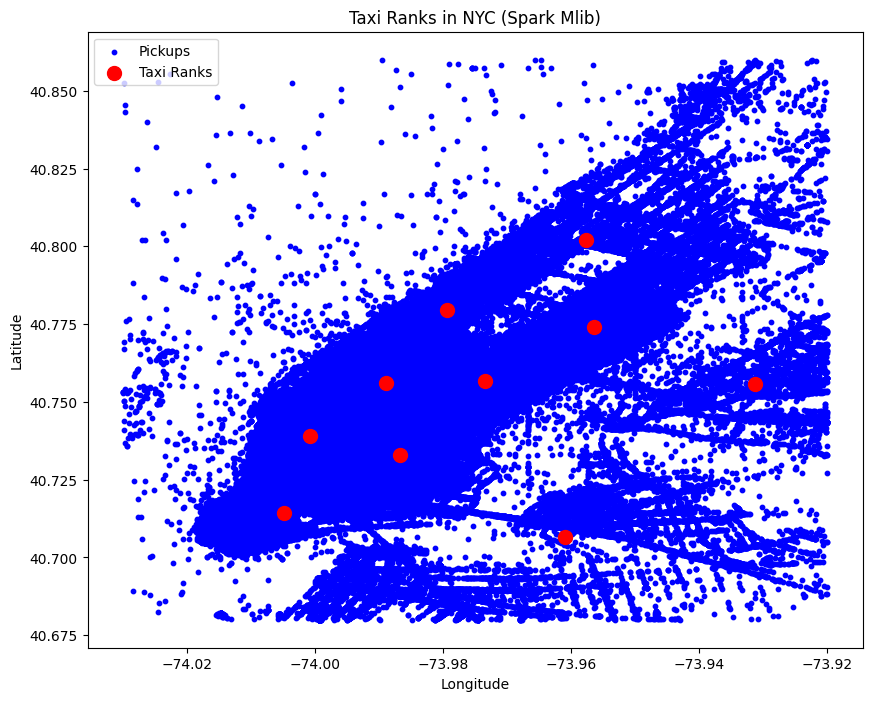

In [ ]:
# COMPLETE with code using Spark Mlib
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.linalg import Vectors

# Start timing
start_time = time.time()

# Convert pickups to Spark DF with features column
pickup_df = spark.createDataFrame([(Vectors.dense(row[0], row[1]),) for row in nyc_pickups], ["features"])

# Apply Spark MLib Kmeans clustering to find the taxi ranks
kmeans_spark = SparkKMeans(k=10, seed=42)
model = kmeans_spark.fit(pickup_df)

# Get cluster centers
centers = model.clusterCenters()

# End timing
end_time = time.time()

# Print execution time
print("Execution time (Spark MLib):", end_time - start_time)

# Plot the results as a heatmap
plt.figure(figsize=(10,8))
plt.scatter(pickup_coords[:,0], pickup_coords[:,1], c='blue', s=10, label='Pickups')
plt.scatter([center[0] for center in centers], [center[1] for center in centers], c='red', s=100, label='Taxi Ranks')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Taxi Ranks in NYC (Spark Mlib)')
plt.legend()
plt.show()

**Execution times:**

scikit-learn: **4.70s**

cuML: **1.87s**

Spark Mlib: **102.27s**


#### Discussion

**Code explanation**

All 3 solutions attempt to identify taxi ranks in NYC by clustering taxi pickup locations, using scikit-learn, cuML, and Spark MLib.
- Scikit-learn: It was used KMeans clustering, which is a commonly used machine learning algorithm for clustering. The dataset was converted into a numpy array after filtering the data points that fall within the specified latitude and longitude boundaries. Then it was applied KMeans clustering to identify clusters that represent the most likely taxi ranks.
- cuML: It was applied KMeans using cuML, which is part of the RAPIDS suite and leverages GPU acceleration for faster computation. The code uses cuML KMeans class to perform clustering on the pickup coodinates. The fit() method is used to fit the model to the data and determine the cluster centers (taxi ranks).
- Spark MLib: The code uses Spark MLib's KMeans algorithm to performance clustering on the pickup data. First, the pickup data is converted into a Spark DataFrame where each row constains a feature column with the pickup coordinates (longitude, latitude). Spark uses a distributed computational model so the dataset is partitioned and processed across multiple workers in a Spark cluster. Each worker processes a portion of the data, and the results are aggregated.

**Execution time**

Scikit-learn performs well on smaller datasets, providing quick results. The clustering is done on a single machine using CPU, which works efficiently for this dataset size. cuML delivers the faster execution, as it leverages GPU acceleration to perform the clustering. For large datasets, cuML would outperform both scikit-learn and Spark. While Spark MLib is great for very large datasets and distributed computation, it comes with overheads related to data shuffling and distributed execution. For smaller datasets like the one in this exercise, it takes longer compared to the other two methods.

**Results**

The differences in the points (taxi ranks) across methods arise from variations in how the KMeans clustering is implemented in each framework. These differences include the initialization of centroids, precision of data handling, convergence criteria, and how the data is processed.

**Conclusion**

For small to medium-sized datasets. scikit-learn and cuML are optional choices, with cuML offering the fastest results when GPU resources are available. Spark MLib is a great option for large datasets but introduces complexity and overhead for smaller datasets like this one.